# Mental Health in the Tech Industry Analysis

---
## Sources and Links
Kaggle dataset : [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry)

Website used to create ERD : [dbdiagram.io](https://dbdiagram.io)

---
# Overview

- title

- sources and links

- overview

- imports

- business understanding

- data understanding

- methodoligy

- functions

- exploritory data analisys

---
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pandasql import sqldf

---
# Business understanding

---
# Data Understanding

---
# Methodoligy

---
# Functions

In [2]:
def normalize_gender(gender):
    g = gender.lower().strip()
    if g in ['male', 'man', 'cis male', 'cis man', 'masculine']:
        return 'male'
    elif g in ['female', 'f', 'woman', 'cis female', 'cis woman', 'femanine']:
        return 'female'
    elif 'trans' in g:
        return 'trans'
    elif 'non-binary' in g or 'genderqueer' in g or 'genderfluid' in g:
        return 'non-binary'
    elif g in ['na', 'n/a', '', 'none', 'no']:
        return 'prefer not to say'
    else:
        return 'other'

# Exploritory Data Analysis

In [3]:
conn = sqlite3.connect('mental_health.sqlite')

In [4]:
tables_query = "select name from sqlite_master where type = 'table';"
tables = pd.read_sql(tables_query, conn)
tables

,name
0,Answer
1,Question
2,Survey


Here we have an `Entity Relationship Diagram` or `ERD` for short. This is a visual representation of how the tables in our SQL file are connected. Link above in the _sources and links_ section.

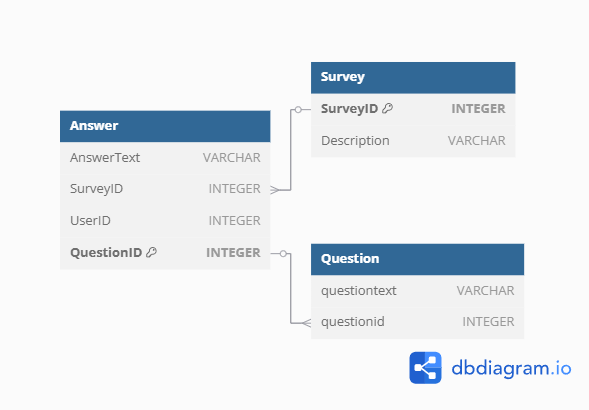

In [5]:
pd.read_sql('''
select *
from Question;
''', conn)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [6]:
pd.read_sql('''
select *
from Answer;
''', conn)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [7]:
pd.read_sql('''
select *
from Survey;
''', conn)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [8]:
pd.read_sql('''
select answertext as answer, count(*) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'What is your gender?'
group by a.answertext
order by count desc
''',conn)

,answer,count
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
...,...,...
96,Agender/genderfluid,1
97,Agender trans woman,1
98,AFAB,1
99,A little about you,1


In [9]:
pd.read_sql('''
select description
from survey
''',conn)

,Description
0,mental health survey for 2014
1,mental health survey for 2016
2,mental health survey for 2017
3,mental health survey for 2018
4,mental health survey for 2019


---
# Data Insight

- whats the age spread and gender breakdown

- what jobs and industries are represented in the data

## Gender breakdown

In [10]:
pd.read_sql('''
select answertext, count(answertext) as count
from Question as q
left join Answer as a
on q.questionid = a.questionid
where questiontext = 'What is your gender?'
group by answertext
''', conn)

,AnswerText,count
0,-1,24
1,43,1
2,A little about you,1
3,AFAB,1
4,Agender,4
...,...,...
96,something kinda male?,1
97,sometimes,1
98,trans woman,1
99,transgender,1


In [11]:
df_gender_spread = pd.read_sql('''
select answertext, count(answertext) as count
from Question as q
left join Answer as a
on q.questionid = a.questionid
where questiontext = 'What is your gender?'
group by answertext
''', conn)

In [12]:
with pd.option_context('display.max_rows', None):
    print(df_gender_spread['AnswerText'].value_counts())

AnswerText
-1                                                1
Transitioned, M2F                                 1
gender non-conforming woman                       1
fm                                                1
fluid                                             1
femmina                                           1
female-bodied; no feelings about gender           1
female                                            1
agender                                           1
\-                                                1
Woman-identified                                  1
Unicorn                                           1
Transgender woman                                 1
Other                                             1
Transfeminine                                     1
Trans-female                                      1
Trans woman                                       1
Trans non-binary/genderfluid                      1
Trans man                                         1
T

In [13]:
df_gender_spread['gender'] = df_gender_spread['AnswerText'].apply(normalize_gender)

In [14]:
df_gender_spread['gender'].value_counts()

gender
other                64
non-binary           15
trans                14
male                  4
female                2
prefer not to say     2
Name: count, dtype: int64

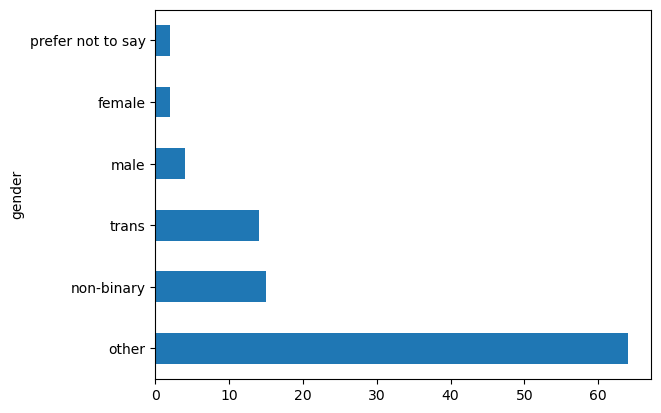

In [15]:
df_gender_spread['gender'].value_counts().plot(kind = 'barh')
plt.show();

## Age Spread

In [16]:
pd.read_sql('''
select answertext
from answer as a 
left join question as q 
on a.questionid = q.questionid
where questiontext = 'What is your age?'
group by answertext;
''', conn)

,AnswerText
0,-1
1,-29
2,0
3,11
4,15
...,...
60,70
61,72
62,74
63,8


In [17]:
df_age_spread = pd.read_sql('''
select cast(answertext as integer) as age
from answer as a 
left join question as q 
on a.questionid = q.questionid
where q.questiontext = 'What is your age?' and
age between 1 and 80
group by age
order by age asc;
''', conn)

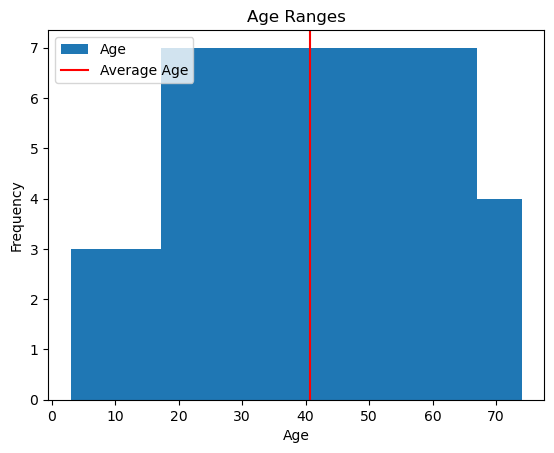

In [18]:
fig, ax = plt.subplots()

df_age_spread['age'].astype(int).plot(kind = 'hist')
avg_age = round(sum(df_age_spread['age']) / len(df_age_spread['age']), 1)

ax.axvline(avg_age, color = 'r')
ax.set_xlabel('Age')
ax.set_title('Age Ranges')
plt.legend(['Age','Average Age'])
plt.show();

In [19]:
avg_age

40.7

In [20]:
print(f'25% of ages are below {np.percentile(df_age_spread['age'], 25)}')
print(f'50% of ages are below {np.percentile(df_age_spread['age'], 50)}')
print(f'75% of ages are below {np.percentile(df_age_spread['age'], 75)}')

25% of ages are below 26.5
50% of ages are below 41.0
75% of ages are below 55.5


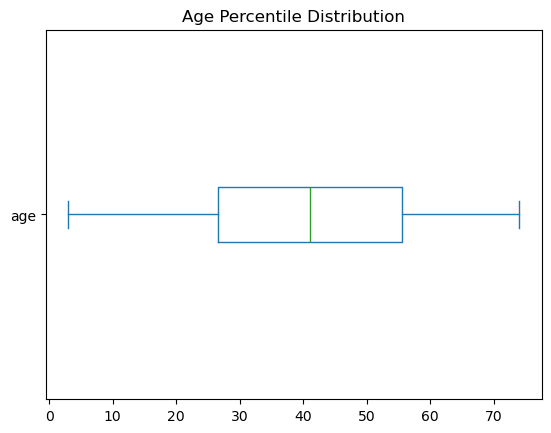

In [21]:
fig, ax = plt.subplots()

df_age_spread['age'].plot(kind = 'box', vert = False)

ax.set_title('Age Percentile Distribution')
plt.show();

---
## Industry Representation

In [22]:
df_question = pd.read_sql('''
select questiontext
from question as q
''',conn)

In [23]:
#pd.set_option('display.max_colwidth', None)
#for f in df_question.iterrows():
#    print(f)

(0, questiontext    What is your age?
Name: 0, dtype: object)
(1, questiontext    What is your gender?
Name: 1, dtype: object)
(2, questiontext    What country do you live in?
Name: 2, dtype: object)
(3, questiontext    If you live in the United States, which state or territory do you live in?
Name: 3, dtype: object)
(4, questiontext    Are you self-employed?
Name: 4, dtype: object)
(5, questiontext    Do you have a family history of mental illness?
Name: 5, dtype: object)
(6, questiontext    Have you ever sought treatment for a mental health disorder from a mental health professional?
Name: 6, dtype: object)
(7, questiontext    How many employees does your company or organization have?
Name: 7, dtype: object)
(8, questiontext    Is your employer primarily a tech company/organization?
Name: 8, dtype: object)
(9, questiontext    Does your employer provide mental health benefits as part of healthcare coverage?
Name: 9, dtype: object)
(10, questiontext    Is your anonymity protected if yo

In [24]:
pd.read_sql('''
select questiontext
from question as q
where questionid = 9
''',conn)

,questiontext
0,Is your employer primarily a tech company/organization?


In [25]:
pd.read_sql('''
select answertext, count(answertext) as count
from answer as a 
where questionid = 9
group by answertext
''',conn)

,AnswerText,count
0,-1,504
1,0,826
2,1,2888


In [26]:
pd.read_sql('''
select questiontext
from question as q
where questionid = 13
''',conn)

,questiontext
0,Is your primary role within your company related to tech/IT?


In [27]:
pd.read_sql('''
select answertext, count(answertext) as count
from question as q
left join answer as a
 on q.questionid = a.questionid
where q.questionid = 13
group by answertext
''',conn)

,AnswerText,count
0,-1,1387
1,0,100
2,1,1471


In [28]:
pd.read_sql('''
select questiontext
from question
where questiontext = 'Which of the following best describes your work position?'
''',conn)

,questiontext
0,Which of the following best describes your work position?


In [29]:
pd.read_sql('''
select answertext, count(answertext) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Which of the following best describes your work position?'
group by answertext
order by count desc
''',conn)

,AnswerText,count
0,Back-end Developer,737
1,Front-end Developer,502
2,DevOps/SysAdmin,282
3,Supervisor/Team Lead,277
4,Other,187
5,Support,168
6,One-person shop,161
7,Designer,135
8,Executive Leadership,101
9,Dev Evangelist/Advocate,99


In [30]:
job_spread = pd.read_sql('''
select answertext as job, count(answertext) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Which of the following best describes your work position?'
group by job
order by count desc
''',conn)

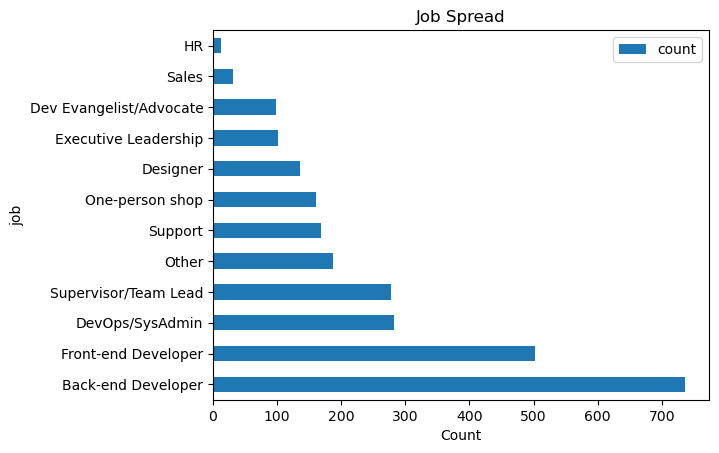

In [47]:
fig, ax = plt.subplots()
job_spread.plot(x = 'job', kind = 'barh', ax = ax)

ax.set_title('Job Spread')
ax.set_xlabel('Count')
plt.show();

In [48]:
for index, row in job_spread.iterrows():
    job = row['job']
    s = job_spread[job_spread['job'] == job]['count'].values[0]
    l = sum(job_spread['count'])
    t = round((s / l) * 100, 2)
    print(f'{job} is {t}% of the answers in this survey, sitting at {s} in total.\n')

Back-end Developer is 27.38% of the answers in this survey, sitting at 737 in total.

Front-end Developer is 18.65% of the answers in this survey, sitting at 502 in total.

DevOps/SysAdmin is 10.48% of the answers in this survey, sitting at 282 in total.

Supervisor/Team Lead is 10.29% of the answers in this survey, sitting at 277 in total.

Other is 6.95% of the answers in this survey, sitting at 187 in total.

Support is 6.24% of the answers in this survey, sitting at 168 in total.

One-person shop is 5.98% of the answers in this survey, sitting at 161 in total.

Designer is 5.01% of the answers in this survey, sitting at 135 in total.

Executive Leadership is 3.75% of the answers in this survey, sitting at 101 in total.

Dev Evangelist/Advocate is 3.68% of the answers in this survey, sitting at 99 in total.

Sales is 1.15% of the answers in this survey, sitting at 31 in total.

HR is 0.45% of the answers in this survey, sitting at 12 in total.



In [35]:
s = job_spread[job_spread['job'] == 'Back-end Developer']['count']
l = sum(job_spread['count'])
t = (s / l) * 100
print(t)

0    27.377415
Name: count, dtype: float64


In [36]:
job_spread[job_spread['job'] == 'Back-end Developer']['count']

0    737
Name: count, dtype: int64

In [37]:
job_spread['count'].sum()

2692

In [38]:
(737 / 2692) * 100

27.377414561664192

In [39]:
pd.read_sql('''
select questiontext
from question as q
''',conn)

,questiontext
0,What is your age?
1,What is your gender?
2,What country do you live in?
3,"If you live in the United States, which state or territory do you live in?"
4,Are you self-employed?
...,...
100,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
101,"If yes, what condition(s) have you been diagnosed with?"
102,"If maybe, what condition(s) do you believe you have?"
103,Which of the following best describes your work position?
